## Step1: Installed pytorch

In [1]:
import torch
print(torch.__version__)

2.3.0+cu121


## Step 2: Import Libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
import time
import matplotlib.pyplot as plt
import numpy as np

## Step 3: Settings(mention batch size, epochs, checked device compatibility) 

In [3]:
BATCH_SIZE = 64
NUM_EPOCHS = 20
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Step4: Prepare the data

In [4]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data',
train=True,
download=True,
transform=transform)
valid_dataset = datasets.MNIST(root='./data',
train=True,
transform=transform)
test_dataset = datasets.MNIST(root='./data',
train=False,
transform=transform)

## Splitted the training dataset into training and validation sets, allowing for model evaluation during training.

In [5]:
validation_fraction = 0.1

## Creating Subset Indices

In [6]:
num = int(validation_fraction * 60000)
train_indices = torch.arange(0, 60000 - num)
valid_indices = torch.arange(60000 - num, 60000)

## train_sampler and valid_sampler are created using SubsetRandomSampler

In [7]:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

## DataLoader

In [8]:
train_loader = DataLoader(dataset = train_dataset, batch_size=BATCH_SIZE, drop_last=True, sampler=train_sampler)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, sampler=valid_sampler)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Checking the dataset

In [9]:
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([64, 1, 28, 28])
Image label dimensions: torch.Size([64])


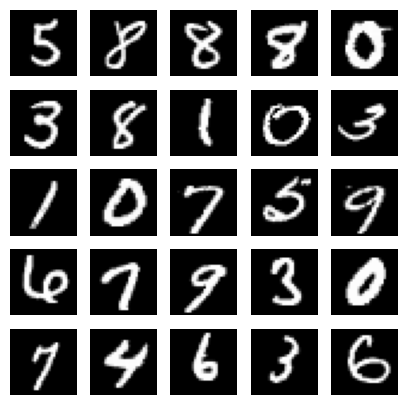

In [10]:
# Display a grid of sample images
plt.figure(figsize=(5, 5))
for i, (images, labels) in enumerate(train_loader):
    for j in range(25):
        plt.subplot(5, 5, j + 1)
        plt.imshow(images[j].squeeze(), cmap='gray')
        plt.axis('off')
    break
plt.show()

### Step5: Defining the MLP model using Pytorch's nn.Module class

In [11]:
class MLP(nn.Module):
    def __init__(self, num_features, num_hidden_1, num_hidden_2, num_classes):
        super().__init__()
        self.network = torch.nn.Sequential(
            # 1st hidden layer
            torch.nn.Flatten(),
            torch.nn.Linear(num_features, num_hidden_1),
            torch.nn.BatchNorm1d(num_hidden_1),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            # 2nd hidden layer
            torch.nn.Linear(num_hidden_1, num_hidden_2),
            torch.nn.BatchNorm1d(num_hidden_2),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            # output layer
            torch.nn.Linear(num_hidden_2, num_classes)
        )
    def forward(self, x):
        logits = self.network(x)
        return logits

### Step 6: Initialize Model, Loss Function, Optimizer, and Scheduler

In [12]:
model = MLP(num_features=28*28,
            num_hidden_1=128,
            num_hidden_2=64,
            num_classes=10)
model = model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9,
weight_decay=0.0001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, mode='min')

In [13]:
# Define your optimizer (using Adam)
#optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
# Create the scheduler with step decay which reduces the learning rate by a factor after a fixed number of epochs.
scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
# Create the scheduler with exponential decay
#scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

### Step7: Training and testing

In [15]:
def compute_accuracy(data_loader):
    with torch.no_grad():
        correct_pred, num_examples = 0, 0
        for i, (features, targets) in enumerate(data_loader):
            features = features.to(DEVICE)
            targets = targets.float().to(DEVICE)
            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [16]:
start_time = time.time()
minibatch_loss_list, train_acc_list, valid_acc_list = [], [], []
for epoch in range(NUM_EPOCHS):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
        # ## FORWARD AND BACK PROP
        logits = model(features)
        #loss = F.cross_entropy(logits, targets)
        loss = criterion(logits, targets)
        optimizer.zero_grad()
        loss.backward()
        # ## UPDATE MODEL PARAMETERS
        optimizer.step()
        # ## LOGGING
        minibatch_loss_list.append(loss.item())
        logging_interval = 100
        if not batch_idx % logging_interval:
            print("Epoch: ", epoch+1,"/", NUM_EPOCHS,"| Batch ",batch_idx, "/",len(train_loader), f'| Loss: {loss:.4f}')
    model.eval()
    with torch.no_grad(): # save memory during inference
        train_acc = compute_accuracy(train_loader)
        valid_acc = compute_accuracy(valid_loader)
        print("Epoch: ", epoch+1, "/",NUM_EPOCHS, f'| Train: {train_acc :.2f}% 'f'| Validation: {valid_acc :.2f}%')
        train_acc_list.append(train_acc.item())
        valid_acc_list.append(valid_acc.item())
    elapsed = (time.time() - start_time)/60
    print("Time elapsed: ",elapsed, " min")
    scheduler.step(minibatch_loss_list[-1])
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')
test_acc = compute_accuracy(test_loader)
print(f'Test accuracy {test_acc :.2f}%')

Epoch:  1 / 20 | Batch  0 / 843 | Loss: 2.4079
Epoch:  1 / 20 | Batch  100 / 843 | Loss: 0.6325
Epoch:  1 / 20 | Batch  200 / 843 | Loss: 0.3818
Epoch:  1 / 20 | Batch  300 / 843 | Loss: 0.3174
Epoch:  1 / 20 | Batch  400 / 843 | Loss: 0.4341
Epoch:  1 / 20 | Batch  500 / 843 | Loss: 0.2313
Epoch:  1 / 20 | Batch  600 / 843 | Loss: 0.2770
Epoch:  1 / 20 | Batch  700 / 843 | Loss: 0.4882
Epoch:  1 / 20 | Batch  800 / 843 | Loss: 0.3484
Epoch:  1 / 20 | Train: 94.98% | Validation: 95.87%
Time elapsed:  0.3754333217938741  min
Epoch:  2 / 20 | Batch  0 / 843 | Loss: 0.2454


/home/usd.local/pooja.singh/anaconda3/envs/myUsdProj/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch:  2 / 20 | Batch  100 / 843 | Loss: 0.5739
Epoch:  2 / 20 | Batch  200 / 843 | Loss: 0.2615
Epoch:  2 / 20 | Batch  300 / 843 | Loss: 0.2298
Epoch:  2 / 20 | Batch  400 / 843 | Loss: 0.2937
Epoch:  2 / 20 | Batch  500 / 843 | Loss: 0.4150
Epoch:  2 / 20 | Batch  600 / 843 | Loss: 0.1946
Epoch:  2 / 20 | Batch  700 / 843 | Loss: 0.3452
Epoch:  2 / 20 | Batch  800 / 843 | Loss: 0.2746
Epoch:  2 / 20 | Train: 95.99% | Validation: 97.13%
Time elapsed:  0.746038826306661  min
Epoch:  3 / 20 | Batch  0 / 843 | Loss: 0.2829
Epoch:  3 / 20 | Batch  100 / 843 | Loss: 0.3646
Epoch:  3 / 20 | Batch  200 / 843 | Loss: 0.1917
Epoch:  3 / 20 | Batch  300 / 843 | Loss: 0.3694
Epoch:  3 / 20 | Batch  400 / 843 | Loss: 0.2174
Epoch:  3 / 20 | Batch  500 / 843 | Loss: 0.2312
Epoch:  3 / 20 | Batch  600 / 843 | Loss: 0.2169
Epoch:  3 / 20 | Batch  700 / 843 | Loss: 0.1707
Epoch:  3 / 20 | Batch  800 / 843 | Loss: 0.1265
Epoch:  3 / 20 | Train: 96.53% | Validation: 97.17%
Time elapsed:  1.1135048747

### Visualizing the training progress by plotting the minibatch loss over iterationsss')


Text(0, 0.5, 'Loss')

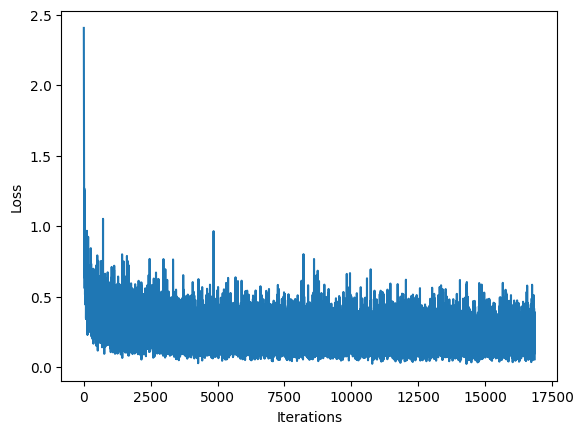

In [17]:
plt.plot(range(len(minibatch_loss_list)), minibatch_loss_list)
plt.xlabel('Iterations')
plt.ylabel('Loss')

###  Plot comparing the training and validation accuracies over epochs

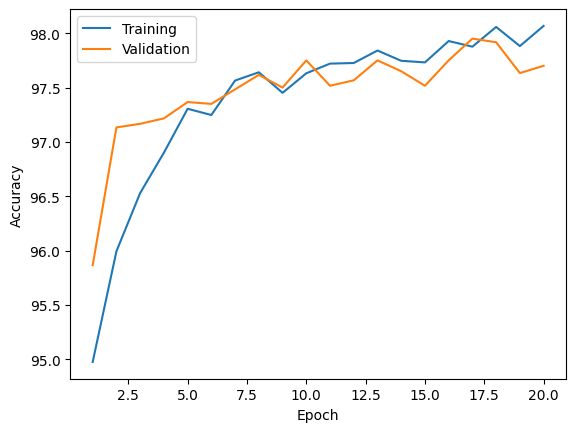

In [18]:
num_epochs = len(train_acc_list)
plt.plot(np.arange(1, num_epochs+1), train_acc_list, label='Training')
plt.plot(np.arange(1, num_epochs+1), valid_acc_list, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()